# Transfer Learning using MobileNetV2 to Classify Images in CIFAR-10 

This project explores the use of transfer learning to perform image classification on the CIFAR-10 dataset. MobileNetV2 has been selected as it has been designed with mobile devices in mind to support mobile visual recognition including classification, object detection and semantic segmentation. 

As CIFAR-10 images have size of 32x32 and MobileNetV2 requires input images to have minimum size of 96x96, the images have to be resized accordingly. With MobileNetV2 as feature extractor and fully connected layers added to perform classification, the model was able to achieve 86.3% accuracy.

## Setup

In [1]:
#import relevant packages
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.applications import MobileNetV2
from keras.datasets import cifar10
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import load_model

import cv2

import sys
import numpy as np
import csv
import math

import matplotlib.pyplot as plt

TensorFlow 1.x selected.


Using TensorFlow backend.


## Import Dataset

In [2]:
# Class names for different classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

# Load training data, labels; and testing data and their true labels
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print ('Training data seize:', train_images.shape, 'Test data size', test_images.shape)

# Normalize pixel values between -1 and 1
train_images = train_images / 127.5 - 1 
test_images = test_images / 127.5 - 1 

170500096/170498071 [==============================] - 5s 0us/step
Training data seize: (50000, 32, 32, 3) Test data size (10000, 32, 32, 3)


## Visualize dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

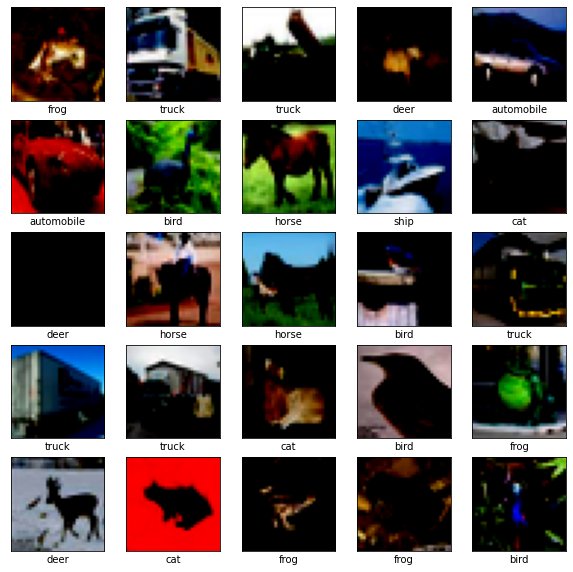

In [3]:
%matplotlib inline
#Show first 25 training images below
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])

## Resize images to use MobileNetV2

In [4]:
# Resize all training and testing images from 32x32 to 96x96 to meet the minimum size required for MobileNetV2
minSize = 96 

# create a numpy array to store all resized training images
resized_train_images = np.zeros((50000, minSize, minSize, 3), dtype=np.float32)
for i in range(train_images.shape[0]):
    resized_train_images[i] = cv2.resize(train_images[i], (minSize, minSize), interpolation=cv2.INTER_AREA)

# create a numpy array to store all resized test images
resized_test_images = np.zeros((10000, minSize, minSize, 3), dtype=np.float32)
for i in range(test_images.shape[0]):
    resized_test_images[i] = cv2.resize(test_images[i], (minSize, minSize), interpolation=cv2.INTER_AREA)

## Download MobileNetV2 model for Feature Extraction



In [5]:
# Download MobileNetV2 and remove final output layer
base_model = MobileNetV2(input_shape=(minSize,minSize,3),
                         include_top=False,
                         weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
9412608/9406464 [==============================] - 1s 0us/step


## Extend MobileNetV2 

In [6]:
# Add custom layers to extend MobileNetV2
base_model.trainable = True
model = Sequential([base_model,
                    GlobalAveragePooling2D(),      #create average pooled feature maps as summarized version of the extracted features
                    Dense(512, activation='relu'), #fully connected layer with 512 nodes
                    Dropout(0.5),                  #dropout to minimise overfitting on data
                    Dense(10, activation='softmax')]) #10 nodes as there are 10 classes to predict in dataset

#view model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 2,918,986
Trainable params: 2,884,874
Non-trainable params: 34,112
_________________________________________________________________


## Add loss function and train the model

In [7]:
#compile model
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#set number of epochs
epochs = 30

#set early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

#set ModelCheckpoint callback
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

#fit model
history = model.fit(resized_train_images, train_labels, batch_size = 32, epochs = epochs, validation_split=0.25, callbacks=[es,mc])


Train on 37500 samples, validate on 12500 samples
Epoch 1/30
37500/37500 [==============================] - 91s 2ms/step - loss: 0.7645 - accuracy: 0.7587 - val_loss: 7.3373 - val_accuracy: 0.2365

Epoch 00001: val_accuracy improved from -inf to 0.23648, saving model to best_model.h5
Epoch 2/30
37500/37500 [==============================] - 77s 2ms/step - loss: 0.5230 - accuracy: 0.8345 - val_loss: 5.7345 - val_accuracy: 0.3106

Epoch 00002: val_accuracy improved from 0.23648 to 0.31064, saving model to best_model.h5
Epoch 3/30
37500/37500 [==============================] - 78s 2ms/step - loss: 0.4485 - accuracy: 0.8566 - val_loss: 1.5314 - val_accuracy: 0.6878

Epoch 00003: val_accuracy improved from 0.31064 to 0.68776, saving model to best_model.h5
Epoch 4/30
37500/37500 [==============================] - 77s 2ms/step - loss: 0.3899 - accuracy: 0.8757 - val_loss: 1.0738 - val_accuracy: 0.7238

Epoch 00004: val_accuracy improved from 0.68776 to 0.72376, saving model to best_model.h5


## Visualise Training and Validation Accuracies and Losses

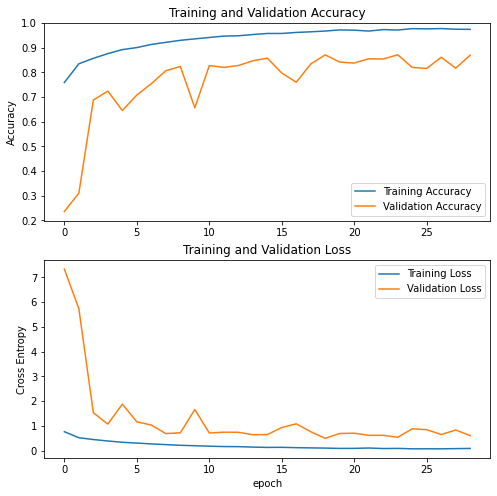

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Save Best Model and Evaluate on Test Dataset

In [9]:
#load the saved model
saved_model = load_model('best_model.h5')

#evaluate model
test_loss, test_acc = model.evaluate(resized_test_images, test_labels)
print(f"Accuracy of trained classifier over entire testing dataset is: {test_acc}")

10000/10000 [==============================] - 4s 435us/step
Accuracy of trained classifier over entire testing dataset is: 0.863099992275238
